In [1]:
%matplotlib inline
import re
import importlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from spiker import *
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "12"
plt.rcParams['legend.fontsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['axes.labelsize']  = '12'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["figure.autolayout"] = True
#from IPython.display import clear_output, Image, display, HTML

In [2]:
# Generate simulation data
def gen_data(nblocks,f1,f2,tseries,amp=1e-9):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    #np.random.seed(1)
    time = tseries.time
    Ts = tseries.Ts
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+1*np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 1*np.sin(2*np.pi*timeblock*f2)+2*np.sin(2*np.pi*timeblock*f1)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op

In [3]:
# Simulation parameters

# Transient simulation parameters for the spiking simulation
Ts = 0.5e-6 # step time
tstart = 0 # Simulation start time in seconds
tstop = 1 # Simulation stop time in seconds
tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
time = tseries.time # the series of time samples


# Neuron constants to setup the neuron model and reserovoir decay
Cmem  = 2e-12 # Membrane cap
Kappa = 0.7
Temp  = 300 # temperature in kelvin
Ut    = 1.38064852e-23 * Temp/1.60217662e-19 # kt/q
Itau  = 50e-12 #50e-12
Ith   = 50e-12 #5e-9
Iin   = 50e-9
gain  = Ith/Itau # DPI gain
tau   = Cmem*Ut/(Kappa * Itau)
print(f'Time constant is {tau} seconds')


# Test data generation
nblocks = 10
f1 = 15
f2 = 4
amp = 10e-9
test_ip, test_op = gen_data(nblocks,f1,f2,tseries,amp)

ip = Tseries(test_ip,time,Ts)
op = Tseries(test_op,time,Ts)

test_ip = np.vstack((amp*np.ones_like(tseries.time),test_ip)) # adding bias

Time constant is 0.001477256629974861 seconds


/home/manuvn/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


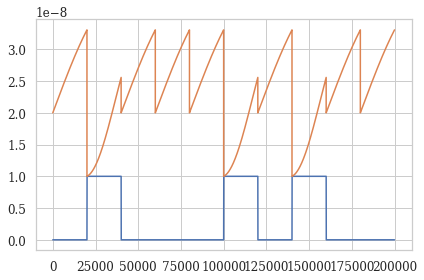

In [4]:
plt.plot(test_op, label='Expected output')
plt.plot(test_ip[1,:], label='Input to be classified')

In [5]:
# --------------------------------
# Standard ESN using real elements
# --------------------------------
def realesn(inSize=1, 
            outSize=1, 
            resSize=20):

    """
    inSize = input dimension
    outSize = output dimension
    resSize = size of the reservoir
    """
    
    # Generate input connectivity weights
    Win = (np.random.rand(resSize,1+inSize)-0.5) * 1

    # Recurrent connecivity weights
    W = np.random.rand(resSize,resSize)-0.5
    # compute the spectral radius
    radius = np.max(np.abs(np.linalg.eigvals(W)))
    # rescale to desired spectral radius
    W = W * (1.0 / radius)

    # Output weights
    Wout = np.random.rand(outSize,1+inSize+resSize)-0.5

    # Generate graph for visualization
    G,W_full = create_graph(W,Win,Wout)
    plt.tight_layout()
    # plt.savefig('ESNgraph.pdf')
    
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)    
    op = np.zeros((outSize,len(tseries.time)))
    x = np.zeros((resSize,1))
    u = np.zeros((inSize+1,))
    states = np.zeros((resSize,len(tseries.time)))
    res = np.zeros((outSize,1))

    t1  = np.zeros((inSize+1,len(tseries.time)))
    t2  = np.zeros((resSize,len(tseries.time)))
    
    # the retention factor inside reservoir = exp(-nsamples_in_tau/a)
    # chosen so that in time 10*tau, the value of exponent is almost 0
    a = 1 - np.exp(-Ts/tau)
    
    for t in range(len(test_ip[0,:])):
        u.shape = (inSize+1,)
        u = (1-a)*u + a*test_ip[:,t] # filtering input
        #u = test_ip[:,t] # filtering input
        u.shape = (len(u),1)
        
        data_in = np.dot( Win, u) # First scale data input
        data_in.shape = (resSize,1) # Reshape for dop product
        
        n_ip = np.dot(W, x) + data_in # Input to neuron
        n_ip = np.maximum(n_ip,0) # Apply relu
        x = (1-a)*x + a*n_ip # filtering inside the neuron
        
        res_ip = np.dot(Wout, np.vstack((u,x))) # Input to readouts
        res_ip = np.maximum(res_ip,0) # Apply relu
        res = (1-a)*res + a*res_ip # Filtering in the readout neurons
       
        # Save state transient output
        x.shape = (resSize,)
        #t1[:,t] = data_in + 0
        #t2[:,t] = res + 0
        states[:,t] = x + 0
        op[:,t] = res[:,0]
        x.shape = (resSize,1)
    return op, states, Win, W, Wout, t1, t2

Total nodes # =  55
Input nodes # =  2
Input neuron # =  2
Reservoir neuron # =  50
Output neuron # =  1


/home/manuvn/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


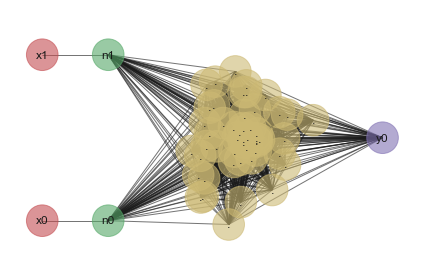

In [6]:
# define reservoir properties
inSize, outSize, resSize = 1, 1, 50

# Let reservoir run
op, res_states, Win, W, Wout, t1_ref, t2_ref = realesn(inSize, outSize, resSize)
plt.savefig('ESNgraph.pdf', dpi=300)

In [7]:
# we'll disregard the first few states and solve for Wout
transient = 0
extended_states = np.concatenate((test_ip, res_states),axis=0)
Wout = np.dot(test_op[transient:], 
               np.linalg.pinv(extended_states[:, transient:]))

/home/manuvn/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


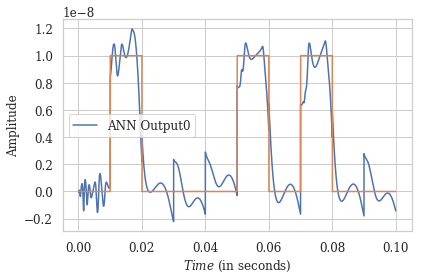

In [8]:
# Compute the output after training
resop = np.dot(Wout, extended_states)
if resop.ndim == 1:
    resop.shape = (1,len(resop))
for index in range(outSize):
    result = Tseries(resop[index,:],tseries.time)
    result.plot(label = "ANN Output"+str(index))
plt.plot(tseries.time, test_op, label = 'Expected output')
#plt.savefig("ANN-ESN.pdf")

In [9]:
# Sigma Delta ESN - numpy
# ---------------------------------
energy_per_spike = 10 # from cadence simulation
def sdesn(Win, Wout, W):
    """
    Runs transient spiking simulation of an Echo-state 
    network given a set of Win, Wout, and W
    Win = Input connectivity matrix
    Wout = Readout connectivity matrix
    W = Recurrent connectivity matrix
    
    # Variables used in this function:
    # X = input: dim = (nip + 1) x 1
    # N = input neurons to convert X to spikes: dim = nip x 1
    # R = reservoir neurons: dim = nres x nres
    # Y = output neurons: dim = nop x 1
    # Wab = weight matrix such that B = W.A
    # Xip = input to the layer X
    # Xop = output from layer X
    """
    nItau    = 50e-12
    nIth     = 50e-12
    nfbItau  = 50e-12
    nfbIth   = 50e-12
    nfbIin   = 40e-9
    neItau   = 10e-12
    neIth    = 50e-9
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)
    X = test_ip
    N = Neuron(nnip,
             ipItau  = nItau,
             ipIth   = nIth,
             fbItau  = nfbItau,
             fbIth   = nfbIth,
             fbIin   = nfbIin,
             eItau   = neItau,
             eIth    = neIth,
             Ts=Ts)
    R = Neuron(nnres,
             ipItau  = nItau,
             ipIth   = nIth,
             fbItau  = nfbItau,
             fbIth   = nfbIth,
             fbIin   = nfbIin,
             eItau   = neItau,
             eIth    = neIth,
             Ts=Ts)
    Y = Neuron(nop,
             ipItau  = nItau,
             ipIth   = nIth,
             fbItau  = nfbItau,
             fbIth   = nfbIth,
             fbIin   = nfbIin,
             eItau   = neItau,
             eIth    = neIth,
             Ts=Ts)
    O = Vsyn(nop,
             Itau  = nItau,
             Ith   = nIth,
             Ts=Ts)    # Readout to LPF neuron output

    Wxn = np.eye(nip)
    Wnr = Win
    Wrr = W
    Wry = Wout
    Wyo = np.eye(nop)
    
    Rop = np.zeros(nnres)
    
    count = nop
    esn = np.zeros((count,len(tseries.time)))
    t1  = np.zeros((nip,len(tseries.time)))
    t2  = np.zeros((nnres,len(tseries.time)))
    t3  = np.zeros((nop,len(tseries.time)))    
    for index in range(len(tseries.time)):
        ip = X[:,index]
    
        Nip = np.dot(Wxn,ip)
        Nop = N.compute(Nip)
        
        Rip = np.dot(Wnr,Nop) + np.dot(Wrr,Rop)
        Rop = R.compute(Rip)
        
        Yip = np.dot(Wry,np.hstack((ip,Rop)))
        Yop = Y.compute(Yip)
        
        O.compute(Yop)
        esn[:,index] = O.states
        t1[:,index] = N.states
        t2[:,index] = R.states
        t3[:,index] = Y.states   
    return esn,count,t1,t2,t3

In [10]:
# Run spiking simulation
esn,count,N,R,Y = sdesn(Win, Wout, W)

In [11]:
_,_,nnip,nnres,nop = compute_nodes(Win,Wout,W)
total_spikes = np.sum(N) + np.sum(R) + np.sum(Y)
print('Input layer spikes = {}'.format(np.sum(N)))
print('Reservoir layer spikes = {}'.format(np.sum(R)))
print('Output layer spikes = {}'.format(np.sum(Y)))
print('Total number of spikes = {}'.format(total_spikes))
avg_spikes_per_neuron = total_spikes/(nnip + nnres + nop)
print('Average number of spikes per neuron = {}'.format(avg_spikes_per_neuron))
print('Spike rate per neuron = {} KHz'.format(10e-3*avg_spikes_per_neuron/tstop))
energy = total_spikes * energy_per_spike
print('Expected energy consumption for this simultion = {} pJ'.format(energy))
power = 10e3* 10e-12 * energy/tstop
print('Power for this simultion = {} mW'.format(power))

Input layer spikes = 83811.0
Reservoir layer spikes = 605873.0
Output layer spikes = 64014.0
Total number of spikes = 753698.0
Average number of spikes per neuron = 14220.716981132075
Spike rate per neuron = 1422.0716981132073 KHz
Expected energy consumption for this simultion = 7536980.0 pJ
Power for this simultion = 7.53698 mW


No handles with labels found to put in legend.
/home/manuvn/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


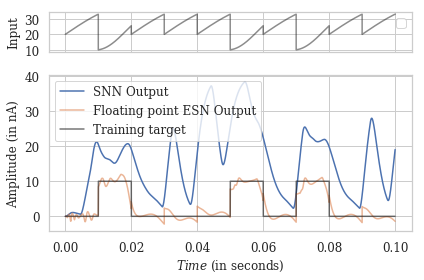

In [12]:
# Generating plots for visualization
f, axarr = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[1, 4]})
plt.sca(axarr[0])
input_signal = Tseries(test_ip[1,:]*1e9, tseries.time[:])
input_signal.plot(ylabeltxt='Input', color='k', xlabel=False,alpha=0.5)
#plt.legend(fancybox = True, frameon = True)

plt.sca(axarr[1])
for index in range(count):
    esnres = Tseries(esn[index,:]*1e9,tseries.time[:])
    esnres.plot(0.0, label = "SNN Output")
    esnres = Tseries(resop[index,transient:]*1e9,tseries.time[transient:])
    esnres.plot(0.0, label = "Floating point ESN Output", alpha = 0.6)

ideal_op = Tseries(test_op*1e9, tseries.time[:])
ideal_op.plot(label = 'Training target', xlabel=False, color='k',alpha=0.6, ylabeltxt='Amplitude (in nA)')

f.subplots_adjust(hspace=0.01)
plt.legend(fancybox = True, frameon = True)
plt.savefig("ANN-SDNN.pdf", dpi=300)

In [13]:
# computing the normalized mean squre error - raw signal
esn_norm = esn[0,:]/max(esn[0,:])
res_norm = resop[0,transient:]/max(resop[0,transient:])
x = np.sum((esn_norm-res_norm)**2)
x = x/len(esn[0,:])
print(f'MSE in the normalized signal is {x}')

MSE in the normalized signal is 0.11884885292511668


In [14]:
# downsample esn_norm
ds_factor=2000
esn_norm = esn[0,:]/max(esn[0,:])
esn_norm_ds = esn_norm[::ds_factor]

res_norm = resop[0,transient:]/max(resop[0,transient:])
res_norm_ds = res_norm[::ds_factor]

In [15]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 1/Ts      # sample rate, Hz
cutoff = 50  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
# w, h = freqz(b, a, worN=8000)
# plt.subplot(2, 1, 1)
# plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
# plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
# plt.axvline(cutoff, color='k')
# plt.xlim(0, 0.5*fs)
# plt.title("Lowpass Filter Frequency Response")
# plt.xlabel('Frequency [Hz]')
# plt.grid()

/home/manuvn/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


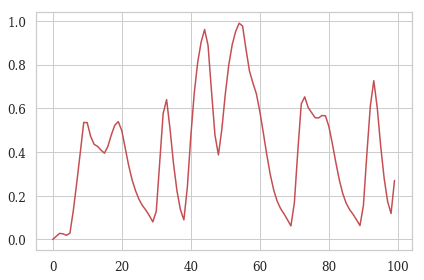

In [17]:
fs = 1/(Ts*ds_factor)
esn_filt = butter_lowpass_filter(esn_norm_ds, cutoff, fs, order)
plt.plot(esn_norm_ds, 'r')

MSE in the normalized filtered signal is 0.2601525104795247


/home/manuvn/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


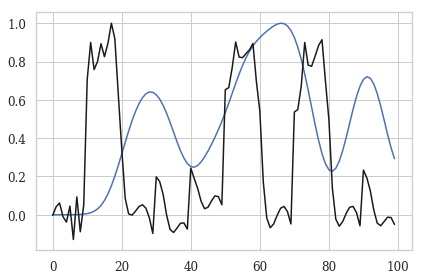

In [18]:
# computing the normalized mean squre error - raw signal
esn_norm_ds_norm = esn_filt/max(esn_filt)
res_norm_ds_norm = res_norm_ds/max(res_norm_ds)
x = np.sum((esn_norm_ds_norm-res_norm_ds_norm)**2)
x = x/len(esn_norm_ds_norm)
plt.plot(esn_norm_ds_norm)
plt.plot(res_norm_ds_norm, 'k')
print(f'MSE in the normalized filtered signal is {x}')